<a href="https://colab.research.google.com/github/FranciscoHernandez1998/lab2-SP1-17004812/blob/master/Lab_2_Clasificador_Binario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Sequential
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import shutil
import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt

plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})
seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

!pip install googleimagedownloader
from googleimagedownloader.googleimagedownloader import GoogleImageDownloader
IMAGE_SIZE = (224, 224)

In [0]:
class_names = ['patrick','spongebob']
path = 'dataset/'

train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

train_ca_dir = os.path.join(train_dir, 'spongebob')  
train_im_dir = os.path.join(train_dir, 'patrick')  
validation_ca_dir = os.path.join(validation_dir, 'spongebob') 
validation_im_dir = os.path.join(validation_dir, 'patrick')  

if os.path.exists(path):
  shutil.rmtree(path)

os.makedirs(train_ca_dir)
os.makedirs(train_im_dir)
os.makedirs(validation_ca_dir)    
os.makedirs(validation_im_dir)

In [0]:
def manage_images(src, dest_train, dest_val, image_resize=IMAGE_SIZE, val_split=0.1, prefix=''):
  total = len(os.listdir(src))
  val = np.int(total*val_split)
  count = 0
  files = os.listdir(src)

  for file_name in files:
    try:
      dest = dest_train if count >= val else dest_val
      dest_file = os.path.join(dest, prefix + file_name) 

      img = Image.open(os.path.join(src,file_name))
      img.verify()
      # reopen because verify() was called
      # If you need to load the image after using this method, you must reopen the image file.
      # https://pillow.readthedocs.io/en/3.1.x/reference/Image.html
      img = Image.open(os.path.join(src,file_name))
      #resize
      img = img.resize(image_resize, Image.ANTIALIAS)
      #move
      img.save(dest_file)  
      count+=1 
    except Exception as e:
        print('Invalid image: ',file_name,e)
        if os.path.exists(dest_file):
          os.remove(dest_file)
  return


In [0]:
img_dir = os.path.realpath('Images/')

In [0]:
queries = ['squarepants','nickelodeon']
pos = 0
for query in queries:
  image = GoogleImageDownloader(Query='spongebob '+query, numberImage=100)
  try:
    image.downloadImages()
  except Exception as e:
    print('Error ',e)
  #verify, resize, move and split sets
  manage_images(img_dir, train_ca_dir, validation_ca_dir,prefix=str(pos)+'-')
  pos+=1

https://www.google.co.in/search?q=spongebob squarepants&source=lnms&tbm=isch
Total Time : 0:00:02.748671
Invalid image:  89.jpg cannot write mode RGBA as JPEG
Invalid image:  3.jpg cannot identify image file '/content/Images/3.jpg'
Invalid image:  80.jpg cannot write mode P as JPEG
Invalid image:  23.jpg cannot write mode RGBA as JPEG
Invalid image:  17.jpg cannot identify image file '/content/Images/17.jpg'
Invalid image:  58.jpg cannot write mode RGBA as JPEG
Invalid image:  41.jpg cannot identify image file '/content/Images/41.jpg'
Invalid image:  83.jpg cannot identify image file '/content/Images/83.jpg'
Invalid image:  29.jpg cannot write mode RGBA as JPEG
Invalid image:  76.jpg cannot write mode RGBA as JPEG
Invalid image:  43.jpg cannot identify image file '/content/Images/43.jpg'
Invalid image:  38.jpg cannot write mode RGBA as JPEG
Invalid image:  93.jpg cannot write mode RGBA as JPEG
Invalid image:  59.jpg cannot write mode RGBA as JPEG
Invalid image:  5.jpg cannot write mode

In [0]:
queries = ['star','pink']
pos = 0
for query in queries:
  image = GoogleImageDownloader(Query='patrick '+query, numberImage=100)
  try:
    image.downloadImages()
  except Exception as e:
    print('Error ',e)
  #verify, resize, move and split sets
  manage_images(img_dir, train_im_dir, validation_im_dir,prefix=str(pos)+'-')
  pos+=1

https://www.google.co.in/search?q=patrick star&source=lnms&tbm=isch
Total Time : 0:00:04.236925
Invalid image:  75.jpg cannot write mode LA as JPEG
Invalid image:  42.jpg cannot write mode RGBA as JPEG
Invalid image:  53.jpg cannot write mode RGBA as JPEG
Invalid image:  78.jpg cannot write mode RGBA as JPEG
Invalid image:  49.jpg cannot write mode P as JPEG
Invalid image:  90.jpg cannot write mode RGBA as JPEG
Invalid image:  34.jpg cannot identify image file '/content/Images/34.jpg'
Invalid image:  33.jpg cannot write mode P as JPEG
Invalid image:  74.jpg cannot write mode P as JPEG
Invalid image:  44.jpg cannot write mode P as JPEG
Invalid image:  91.jpg cannot write mode P as JPEG
Invalid image:  6.jpg cannot write mode P as JPEG
Invalid image:  16.jpg cannot write mode RGBA as JPEG
Invalid image:  18.jpg cannot write mode RGBA as JPEG
Invalid image:  71.jpg cannot write mode RGBA as JPEG
Invalid image:  87.jpg cannot identify image file '/content/Images/87.jpg'
Invalid image:  29.

In [0]:
total_train = len(os.listdir(train_ca_dir))+ len(os.listdir(train_im_dir))
total_val = len(os.listdir(validation_ca_dir))+ len(os.listdir(validation_im_dir))

print('total training Spongebob images:', len(os.listdir(train_ca_dir)))
print('total training Patrick images:', len(os.listdir(train_im_dir)))

print('total validation Spongebob images:', len(os.listdir(validation_ca_dir)))
print('total validation Patrick images:', len(os.listdir(validation_im_dir)))
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training Spongebob images: 147
total training Patrick images: 126
total validation Spongebob images: 20
total validation Patrick images: 20
--
Total training images: 273
Total validation images: 40


In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [0]:
train_data_gen = train_image_generator.flow_from_directory(train_dir,
                                                           shuffle=True,
                                                           batch_size=32,
                                                           target_size=IMAGE_SIZE,
                                                           class_mode='binary')

Found 273 images belonging to 2 classes.


In [0]:
val_data_gen = validation_image_generator.flow_from_directory(validation_dir,
                                                              target_size=IMAGE_SIZE,
                                                              class_mode='binary')

Found 40 images belonging to 2 classes.


In [0]:
image_batch, labels_batch = next(train_data_gen)

In [0]:
classifier_url ="https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4" 
classifier = Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SIZE+(3,))
])

result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [0]:
labels_path = get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['clog', 'balloon', 'Band Aid', 'rubber eraser', 'comic book',
       'comic book', 'totem pole', 'nipple', 'nipple', 'revolver',
       'toyshop', 'jigsaw puzzle', 'toyshop', 'envelope', 'shoe shop',
       'rubber eraser', 'toyshop', 'comic book', 'bib', 'puck',
       'comic book', 'bib', 'slot', 'comic book', 'pencil box', 'racer',
       'trench coat', 'Band Aid', 'envelope', 'comic book', 'comic book',
       'toyshop'], dtype='<U30')

In [0]:
def plot_images(img_batch, labels, predicted_labels):
  plt.figure(figsize=(12,12))
  plt.subplots_adjust(hspace=0.5)
  for i in range(15):
    plt.subplot(6,5,i+1) 
    plt.imshow(img_batch[i])
    color = "green" if predicted_labels[i] == class_names[np.int(labels[i])] else "red"
    plt.title(predicted_labels[i], color=color)
    plt.axis('off')

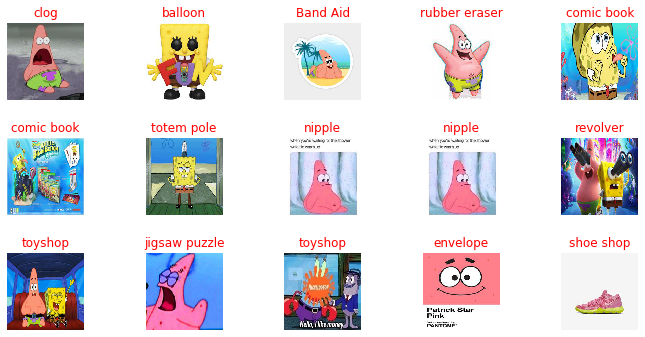

In [0]:
plot_images(image_batch, labels_batch, predicted_class_names)

In [0]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=IMAGE_SIZE+(3,))

In [0]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 2048)


In [0]:
feature_extractor_layer.trainable = False

In [0]:
model = Sequential([
  feature_extractor_layer,
  Dense(1024, activation='relu'),
  Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 1025      
Total params: 25,664,001
Trainable params: 2,099,201
Non-trainable params: 23,564,800
_________________________________________________________________


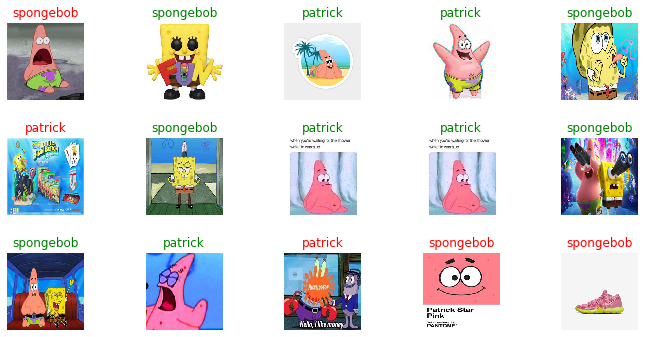

In [0]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()
plot_images(image_batch, labels_batch, predicted_class_names)

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
history = model.fit(
    train_data_gen,
    epochs=5,
    steps_per_epoch=5,
    validation_data=val_data_gen
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 5 steps, validate for 2 steps
Epoch 1/5
5/5 [==============================] - 29s 6s/step - loss: 0.4386 - accuracy: 0.7862 - val_loss: 0.1344 - val_accuracy: 0.9000
Epoch 2/5
5/5 [==============================] - 27s 5s/step - loss: 0.0950 - accuracy: 0.9688 - val_loss: 0.2828 - val_accuracy: 0.9250
Epoch 3/5
5/5 [==============================] - 25s 5s/step - loss: 0.0243 - accuracy: 1.0000 - val_loss: 0.3847 - val_accuracy: 0.9250
Epoch 4/5
5/5 [==============================] - 25s 5s/step - loss: 0.1281 - accuracy: 0.9793 - val_loss: 0.3947 - val_accuracy: 0.9000
Epoch 5/5
5/5 [==============================] - 27s 5s/step - loss: 0.0453 - accuracy: 0.9688 - val_loss: 0.3789 - val_accuracy: 0.8750


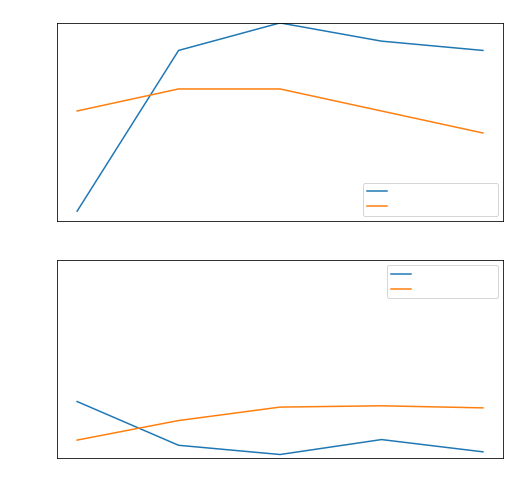

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

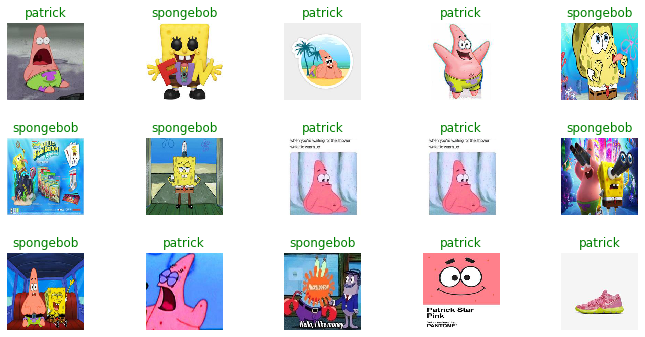

In [0]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()

plot_images(image_batch, labels_batch, predicted_class_names)
